## Note:
this is a workbook notebook for testing the baseline, lstm and cnn model... the final notebook will have much more examples and will have visualization on how the data looks

In [2]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [4]:
full_df.shape

(52696, 5)

In [5]:
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
df.head(10)

(5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,126878,45995,2136-12-05 00:00:00,42823 570 486 5845 2762 5119 4280 42731 41401 ...,Admission Date: [**2136-11-26**] ...
1,183331,12325,2142-08-28 00:00:00,99674 44024 44422 99762 2874 496 7299 25000 4019,Admission Date: [**2142-7-27**] ...
2,105229,16211,2160-08-10 00:00:00,9654 9630 5990 79092,Admission Date: [**2160-8-8**] Discharge ...
3,123016,28052,2104-02-18 00:00:00,431 5070 34290 42611 4019 78723 78194 5939,Admission Date: [**2104-2-9**] D...
4,171608,15929,2140-09-22 00:00:00,41041 9971 42741 41402 41401 4019,Admission Date: [**2140-9-19**] Discharge...
5,125185,69370,2119-10-11 00:00:00,53200 56881 51881 0389 5070 99592 42821 2762 2...,Admission Date: [**2119-10-5**] ...
6,187382,19493,2143-12-27 00:00:00,45829 5571 4111 4019 2724 53081 496 41401 311 ...,Admission Date: [**2143-12-26**] ...
7,187411,58027,2123-01-15 00:00:00,0389 486 78552 5990 70713 6826 07032 99592 459...,Admission Date: [**2123-1-7**] D...
8,152609,14240,2148-11-15 00:00:00,99666 73005 8080 2536 34590 4439 73300,Admission Date: [**2148-11-9**] Dischar...
9,108241,22485,2107-01-24 00:00:00,80600 30390 2910 85011 82300 8240 3051 2536 80...,Admission Date: [**2107-1-14**] ...


## Pre processing ICD 9 codes

In [6]:
# instead of finding out the top 20 leave icd-9 codes and filter records based on that
# we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy
#N_TOP = 20 
#full_df, top_codes = database_selection.filter_top_codes(df, 'ICD9', N_TOP, filter_empty = True)
#df = full_df.head(1000)

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [7]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,126878,45995,2136-12-05 00:00:00,240-279 390-459 460-519 520-579 799 580-629,Admission Date: [**2136-11-26**] ...
1,183331,12325,2142-08-28 00:00:00,240-279 390-459 290-319 460-519 800-999 710-739,Admission Date: [**2142-7-27**] ...
2,105229,16211,2160-08-10 00:00:00,580-629 790-796 800-999,Admission Date: [**2160-8-8**] Discharge ...
3,123016,28052,2104-02-18 00:00:00,580-629 780-789 390-459 460-519 320-389,Admission Date: [**2104-2-9**] D...
4,171608,15929,2140-09-22 00:00:00,390-459 800-999,Admission Date: [**2140-9-19**] Discharge...
5,125185,69370,2119-10-11 00:00:00,240-279 001-139 390-459 290-319 460-519 520-57...,Admission Date: [**2119-10-5**] ...
6,187382,19493,2143-12-27 00:00:00,240-279 390-459 290-319 460-519 520-579 780-789,Admission Date: [**2143-12-26**] ...
7,187411,58027,2123-01-15 00:00:00,240-279 001-139 290-319 390-459 680-709 460-51...,Admission Date: [**2123-1-7**] D...
8,152609,14240,2148-11-15 00:00:00,240-279 390-459 710-739 320-389 800-999,Admission Date: [**2148-11-9**] Dischar...
9,108241,22485,2107-01-24 00:00:00,240-279 290-319 800-999,Admission Date: [**2107-1-14**] ...


In [8]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 4138, '240-279': 3449, '290-319': 2833, '460-519': 2546, '800-999': 2200, '580-629': 2112, '520-579': 2038, '780-789': 1597, '320-389': 1588, '001-139': 1407, '710-739': 1025, '140-239': 838, '680-709': 591, '760-779': 541, '790-796': 461, '799': 166, '630-679': 16})
Number of icd9 codes in the first level that have notes in the dataset: 17


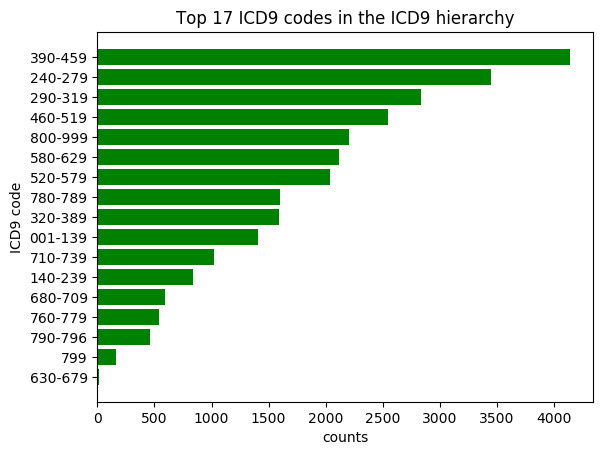

In [9]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [10]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0]


## Pre process Notes

In [30]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 45222
Average note length: 1644.0711575
Max note length: 7470
Final Vocabulary: 45222
Final Max Sequence Length: 5000


In [38]:
print len (df.TEXT[0].split())
print ' admission index:', dictionary["admission"]
print ' date:', dictionary["date"]

print ' words: ', df.TEXT[0].split()[0:100]
print ' '
print ' vectorized: ', data_vectorized[0][0:100]
print len (data_vectorized[0])
print ' '
print 'padded' , data[0]
print len (data[0])

3685
 admission index: 41
 date: 46
 words:  ['admission', 'date', 'discharge', 'date', 'service', 'medicine', 'allergies', 'no', 'known', 'allergies', 'adverse', 'drug', 'reactions', 'attending', 'chief', 'complaint', 'shortness', 'of', 'breath', 'major', 'surgical', 'or', 'invasive', 'procedure', 'right', 'sided', 'pleural', 'effusion', 'drainage', 'with', 'pigtail', 'catheter', 'placement', 'transesophageal', 'echocardiogram', 'with', 'bedside', 'electrical', 'cardioversion', 'history', 'of', 'present', 'illness', 'the', 'patient', 'is', 'a', 'f', 'with', 'a', 'medical', 'history', 'of', 'atrial', 'fibrillation', 'not', 'on', 'coumadin', 'coronary', 'artery', 'disease', 'who', 'is', 'transferred', 'from', 'after', 'presenting', 'there', 'with', 'progressively', 'worsening', 'dyspnea', 'at', 'baseline', 'she', 'ambulates', 'with', 'a', 'walker', 'but', 'does', 'not', 'go', 'very', 'far', 'due', 'to', 'leg', 'pain', 'she', 'had', 'a', 'recent', 'hospitalization', 'several', 'months', 

In [12]:
#creating embeddings
EMBEDDING_LOC = '../data/glove.6B.100d.txt' # location of embedding
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True)


('Vocabulary in notes:', 45223)
('Vocabulary in original embedding:', 400000)
('Vocabulary intersection:', 22029)


## Split Files

In [13]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [13]:
# Delete temporary variables to free some memory
del df, data, labels

## Super Basic Baseline with top 4
Always predict top 4

In [14]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4149), ('240-279', 3476), ('290-319', 2809), ('460-519', 2481)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [15]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [17]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.532      0.526
0.030:      0.532      0.526
0.040:      0.532      0.526
0.050:      0.532      0.526
0.055:      0.532      0.526
0.058:      0.532      0.526
0.060:      0.532      0.526
0.080:      0.532      0.526
0.100:      0.532      0.526
0.200:      0.532      0.526
0.300:      0.532      0.526
0.500:      0.532      0.526


## Basic LSTM 

In [19]:
reload(lstm_model)
#### build model
l_model = lstm_model.build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5000, 100)         4522400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 19)                1919      
Total params: 4,604,719
Trainable params: 4,604,719
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
497s - loss: 0.4698 - acc: 0.7685 - val_loss: 0.4302 - val_acc: 0.7857
Epoch 2/5
498s - loss: 0.4239 - acc: 0.7886 - val_loss: 0.4256 - val_acc: 0.7865
Epoch 3/5
528s - loss: 0.4160 - acc: 0.7946 - val_loss: 0.4173 - val_acc: 0.7941
Epoch 4/5
549s - loss: 0.4076 - acc: 0.7987 - val_loss: 0.4088 - val_acc: 0.7944
Epoch 5/5
470s - loss: 0.4017 - acc: 0.7997 - val_loss: 0.4058 - val_acc: 0.7927


In [22]:
pred_train = l_model.predict(X_train, batch_size=100)
pred_dev = l_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.501      0.506
0.030:      0.510      0.515
0.040:      0.527      0.531
0.050:      0.541      0.546
0.055:      0.550      0.554
0.058:      0.553      0.558
0.060:      0.556      0.560
0.080:      0.573      0.576
0.100:      0.585      0.588
0.200:      0.627      0.628
0.300:      0.651      0.650
0.400:      0.648      0.641
0.500:      0.606      0.585
0.600:      0.524      0.506
0.700:      0.429      0.416


## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [14]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.9,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 5000, 100)     4522400     input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4999, 100)     20100       embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 4998, 100)     30100       embedding_1[0][0]                
___________________________________________________________________________________________

In [15]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
110s - loss: 1.2100 - acc: 0.6914 - val_loss: 0.4687 - val_acc: 0.7804
Epoch 2/5
114s - loss: 0.6159 - acc: 0.7315 - val_loss: 0.4398 - val_acc: 0.7879
Epoch 3/5
115s - loss: 0.5118 - acc: 0.7530 - val_loss: 0.4290 - val_acc: 0.7952
Epoch 4/5
114s - loss: 0.4731 - acc: 0.7718 - val_loss: 0.4209 - val_acc: 0.8000
Epoch 5/5
114s - loss: 0.4509 - acc: 0.7806 - val_loss: 0.4139 - val_acc: 0.8003


In [18]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.494      0.496
0.030:      0.507      0.509
0.040:      0.516      0.519
0.050:      0.525      0.527
0.055:      0.528      0.530
0.058:      0.530      0.532
0.060:      0.532      0.534
0.080:      0.547      0.546
0.100:      0.562      0.560
0.200:      0.622      0.617
0.300:      0.661      0.646
0.400:      0.658      0.636
0.500:      0.595      0.567
0.600:      0.493      0.473
0.700:      0.371      0.348


### TO DO: model for Thresholding
Papers about Thresholding:    

* "Convolutional Neural Network using a Threshold Predictor for Multi-label Speech Act Classification"   
* "A Study on Threshold Selection for Multi-label Classification"   

These papers mention they use a model for thresholding, but it is not the main topic:   
* "A Review on Multi-Label Learning Algorithms"   
* "Large-scale Multi-label Text Classification—Revisiting Neural Networks"*   
* "A multi-label convolutional neural network for automatic image annotation"

### Results with external embeddings = True , no additional training,  top 20
```
F1 scores
threshold | training | dev  
0.020:      0.337      0.329
0.030:      0.360      0.353
0.040:      0.365      0.374
0.050:      0.372      0.375
0.055:      0.370      0.377
0.058:      0.369      0.375
0.060:      0.368      0.375
0.080:      0.348      0.361
0.100:      0.309      0.319
0.200:      0.198      0.208
0.300:      0.157      0.138
0.500:      0.000      0.000
```

### Results with external embeddings = False, top 20
```
F1 scores
threshold | training | dev  
0.020:      0.288      0.300
0.030:      0.327      0.322
0.040:      0.371      0.363
0.050:      0.380      0.391
0.055:      0.412      0.383
0.058:      0.403      0.394
0.060:      0.394      0.389
0.080:      0.385      0.390
0.100:      0.229      0.225
0.200:      0.000      0.000
0.300:      0.000      0.000
0.500:      0.000      0.000
```

### Results with external embedding and training them , top 20
```
F1 scores
threshold | training | dev  
0.020:      0.334      0.333
0.030:      0.362      0.360
0.040:      0.366      0.374
0.050:      0.373      0.380
0.055:      0.374      0.382
0.058:      0.376      0.376
0.060:      0.376      0.378
0.080:      0.387      0.371
0.100:      0.366      0.350
0.200:      0.179      0.171
0.300:      0.020      0.020
0.500:      0.000      0.000

```

### Results with external Embeddings = False, top 10, 
We can compare this setup with the LSTM published in the paper "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records", they got a F1-score of about 0.4168, we are getting 0.447

``` 
F1 scores
threshold | training | dev  
0.020:      0.399      0.407
0.030:      0.399      0.407
0.040:      0.399      0.407
0.050:      0.408      0.413
0.055:      0.433      0.420
0.058:      0.437      0.430
0.060:      0.432      0.427
0.080:      0.501      0.463
0.100:      0.446      0.463
0.200:      0.206      0.066
0.300:      0.000      0.000
0.500:      0.000      0.000
```



## Notes:


(1) There is a LSTM model by this paper: "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records" which did achieve a 42% F1-score. (https://cs224d.stanford.edu/reports/priyanka.pdf), but it only uses the top 10 icd9 codes. We are getting 46% (just running with 1000 notes so far)


(2) The "A Comparison of Rule-Based and Deep Learning Models for Patient Phenotyping"  study did get a 70% F1-score, but they don't use the icd9-labels but phenotypes labels they annotated themselved (via a group of medical professionals). (https://arxiv.org/abs/1703.08705). There were ONLY 10 phenotypes.

The discharge summaries are labeled with ICD9-codes that are leaves in the ICD9-hierarchy (which has hundreds of ICD9-codes), then maybe these leave nodes are too specific and difficult to predict, one experiment would be to replaced all the ICD9-codes with their parent in the second or third level in the hierarchy and see if predictions work better that way.   

(3) our baseline with top 20 codes had a f1-score of 35% (assigning top 4 icd9 codes to all notes, using a CNN with no external embeddings is getting about 40% f1-score.. a little better than the baseline

(4) Papers published and best practices report  that external embeddings improve considerable the model's performance.. maybe it is not the case here because of the medical terms..   

(5) Fixed Thresholding doesn't work well for multilabel classifications, we can implement a model to choose the appropriate threshold for each record (see notes above)

(6) for loss function: binary and categorical cross entropy gave same results